In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from utils import *

In [57]:
DIR = "data/round-1/"

In [122]:
df1 = pd.read_csv(DIR+"prices_round_1_day_-2.csv", delimiter=';')
df2 = pd.read_csv(DIR+"prices_round_1_day_-1.csv", delimiter=';')
df3 = pd.read_csv(DIR+"prices_round_1_day_0.csv", delimiter=';')
PnL = pd.read_csv(DIR+"prices_day_1.csv", delimiter=';')

In [123]:
price = pd.concat((df1, df2, df3, PnL))

In [124]:
RESIN = price.loc[price["product"]=="RAINFOREST_RESIN"].reset_index(drop=True)
KELP = price.loc[price["product"]=="KELP"].reset_index(drop=True)
SQUID = price.loc[price["product"]=="SQUID_INK"].reset_index(drop=True)

In [125]:
mp = get_midprice_mm(KELP)
KELP["mid_price"] = mp
mp2 = get_midprice_mm(SQUID)
SQUID["mid_price"] = mp2

In [126]:
kelp = KELP.loc[KELP["day"]==1]
squid = SQUID.loc[SQUID["day"]==1]

In [127]:
# # get price data

# infile = r"data/round-1/log1.log"
# fp = open(infile)
# start = False
# start_signal = "Activities log"
# end_signal = "Trade History"
# outfile = DIR+"log1-prices.txt"

# with open(outfile, "w") as f:

#     for line in fp:

#         if not start:
#             if start_signal in line:
#                 start = True

#         elif start:
#             if end_signal in line:
#                 break
            
#             f.write(line)
             
# f.close()
# fp.close()


In [129]:
# the entire trade history (not just own trades)
infile = r"data/round-1/log1.log"
hist = get_tradehistory(infile)
resin_hist = get_mytrades(hist)
kelp_hist = get_mytrades(hist, "KELP")
kelp_hist = kelp_hist.merge(kelp[["timestamp", "mid_price"]], on="timestamp", how="left")
# squid_hist = get_mytrades(hist, "SQUID_INK")
# squid_hist = squid_hist.merge(squid[["timestamp", "mid_price"]], on="timestamp", how="left")

### RESIN

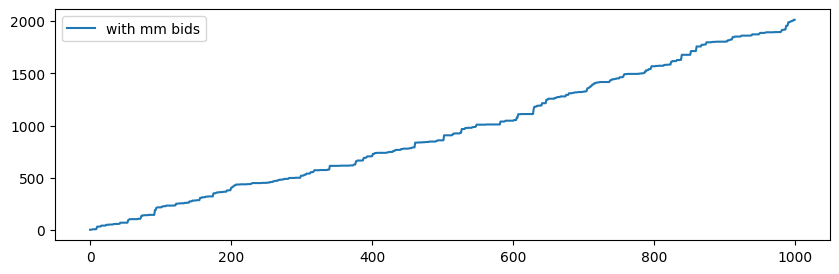

In [130]:
plt.figure(figsize=(10,3))
plt.plot(kelp["timestamp"]/100, PnL.loc[PnL["product"]=="RAINFOREST_RESIN"]["profit_and_loss"], label="with mm bids")
plt.legend()
plt.show()

### KELP

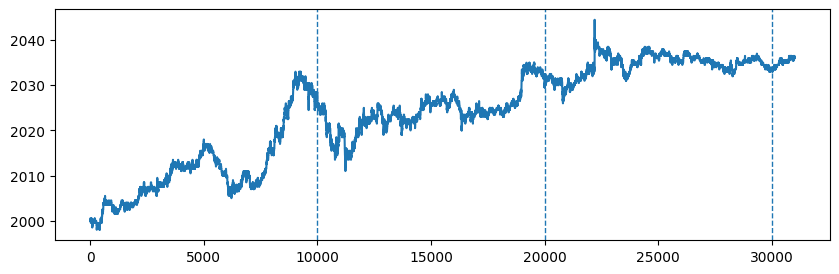

In [131]:
plt.figure(figsize=(10,3))
KELP["mid_price"].plot()
plt.axvline(10000, ls='dashed', lw=1)
plt.axvline(20000, ls='dashed', lw=1)
plt.axvline(30000, ls='dashed', lw=1)


In [132]:
kelp_buy = kelp_hist.loc[kelp_hist["buyer"]=="SUBMISSION"]
kelp_sell = kelp_hist.loc[kelp_hist["seller"]=="SUBMISSION"]
buy_time_kelp = list(kelp_buy["timestamp"])
buy_price_kelp = list(kelp_buy["price"])
sell_time_kelp = list(kelp_sell["timestamp"])
sell_price_kelp = list(kelp_sell["price"])

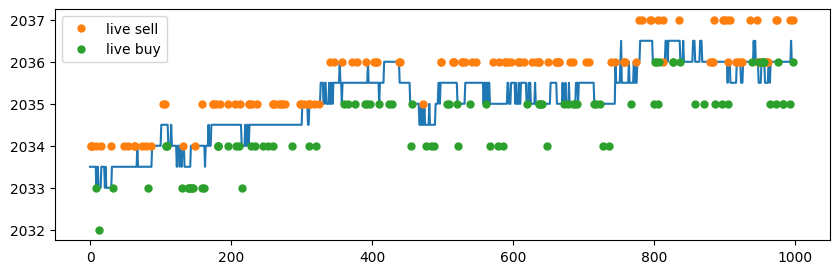

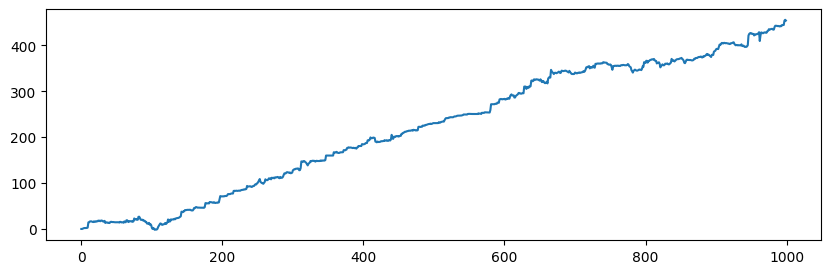

In [136]:
plt.figure(figsize=(10,3))
plt.plot(kelp["timestamp"]/100, kelp["mid_price"])
plt.plot(np.array(sell_time_kelp)/100, sell_price_kelp, lw=0, ms=10, marker='.', label="live sell")
plt.plot(np.array(buy_time_kelp)/100, buy_price_kelp, lw=0, ms=10, marker='.', label="live buy")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(kelp["timestamp"]/100, PnL.loc[PnL["product"]=="KELP"]["profit_and_loss"])
plt.show()

### SQUID

(-20.0, 20.0)

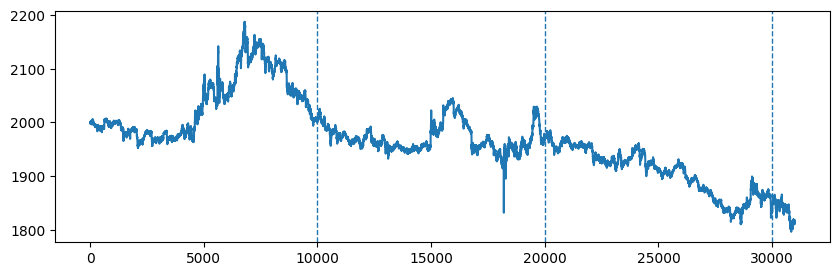

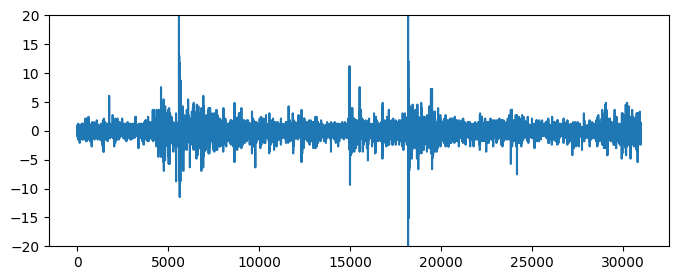

In [181]:
plt.figure(figsize=(10,3))
SQUID["mid_price"].plot()
plt.axvline(10000, ls='dashed', lw=1)
plt.axvline(20000, ls='dashed', lw=1)
plt.axvline(30000, ls='dashed', lw=1)


plt.figure(figsize=(8,3))
diff = SQUID["mid_price"].diff().dropna()
diff = (diff - diff.mean()) / diff.std()
diff.plot()
plt.ylim((-20,20))

In [289]:
class TRADE_SQUID:
    def __init__(self, slow=26, fast=12, signal=9):  
        self.slow = 26
        self.fast = 12
        self.signal = 9
        self.squid_hist = []
        self.squid_flag = False
        self.squid_upper = 0
        self.squid_lower = 0
        self.alpha_fast = 2 / (fast + 1)
        self.alpha_slow = 2 / (slow + 1)
        self.alpha_signal = 2 / (signal + 1)
        self.ema_fast = None
        self.ema_slow = None
        self.macd = None
        self.buy_times = []
        self.sell_times = []
        self.upper_band = []
        self.lower_band = []
    
    def step(self, time, fairprice, window=20, mult=2., threshold=1., hits=3):
        self.squid_hist.append(fairprice)
        if not self.squid_flag:
            if len(self.squid_hist) >= window:
                self.squid_flag = True

        if self.ema_fast is None:
            self.ema_fast = fairprice
            self.ema_slow = fairprice
            self.macd = self.ema_signal = 0 
        else:
            self.ema_fast = self.alpha_fast * fairprice + (1 - self.alpha_fast) * self.ema_fast
            self.ema_slow = self.alpha_slow * fairprice + (1 - self.alpha_slow) * self.ema_slow
            self.ema_signal = self.alpha_signal * self.macd + (1 - self.alpha_signal) * self.ema_signal
            self.macd = self.ema_fast - self.ema_slow
        
        if self.squid_flag:
            sma = np.mean(np.array(self.squid_hist))
            upper = sma + mult * np.std(np.array(self.squid_hist))
            lower = sma - mult * np.std(np.array(self.squid_hist))

            self.upper_band.append(upper)
            self.lower_band.append(lower)

            price_move =  (upper - lower) * threshold
            if fairprice >= upper + price_move or fairprice <= lower - price_move:
                if fairprice >= upper + price_move:
                    self.squid_upper += 1
                    # self.squid_lower = 0
                if fairprice <= lower - price_move:
                    self.squid_lower += 1
                    # self.squid_upper = 0
            else:
                self.squid_upper = 0
                self.squid_lower = 0
            # buy/sell when midprice touches upper/lower band N=hits number of times consecutively
            if self.squid_lower >= hits and self.macd > self.ema_signal:
                self.buy_times.append(time)
            if self.squid_upper >= hits and self.macd < self.ema_signal:
                self.sell_times.append(time)
                
            self.squid_hist = self.squid_hist[1:]


In [290]:
times = SQUID.index
prices = SQUID["mid_price"]
sell = SQUID["bid_price_1"]
buy= SQUID["ask_price_1"]

In [298]:
squid_trader = TRADE_SQUID()
for time in times:
    squid_trader.step(time, prices[time], window=20, mult=2.5, threshold=0.0, hits=1)

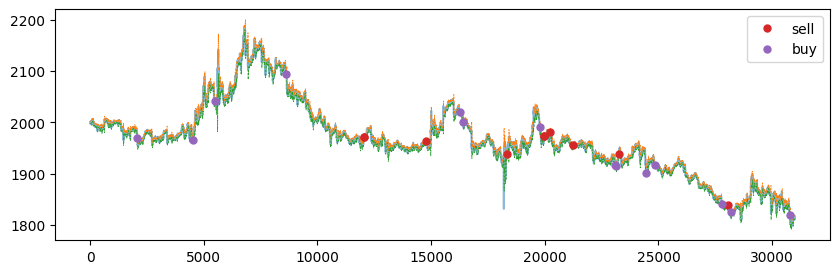

In [299]:
plt.figure(figsize=(10,3))
plt.plot(times, prices, alpha=0.5)
plt.plot(times[19:], squid_trader.upper_band, ls='dashed', lw=0.5)
plt.plot(times[19:], squid_trader.lower_band, ls='dashed', lw=0.5)
plt.plot(squid_trader.sell_times, sell[squid_trader.sell_times], lw=0, ms=10, marker='.', label="sell")
plt.plot(squid_trader.buy_times, buy[squid_trader.buy_times], lw=0, ms=10, marker='.', label="buy")
plt.legend()

In [29]:
squid_buy = squid_hist.loc[squid_hist["buyer"]=="SUBMISSION"]
squid_sell = squid_hist.loc[squid_hist["seller"]=="SUBMISSION"]
buy_time = list(squid_buy["timestamp"])
buy_price = list(squid_buy["price"])
sell_time = list(squid_sell["timestamp"])
sell_price = list(squid_sell["price"])

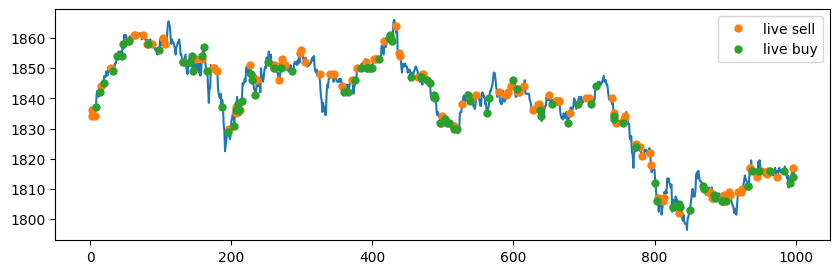

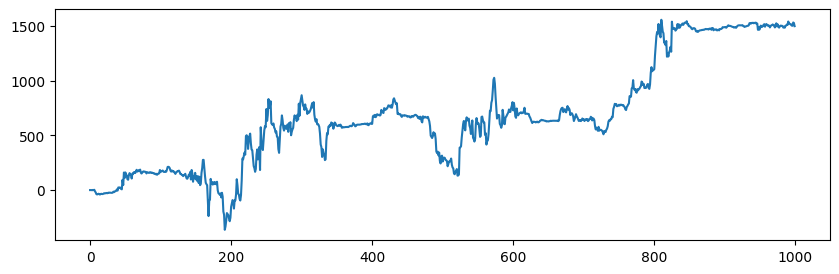

In [30]:
plt.figure(figsize=(10,3))
plt.plot(kelp["timestamp"]/100, squid["mid_price"])
plt.plot(np.array(sell_time)/100, sell_price, lw=0, ms=10, marker='.', label="live sell")
plt.plot(np.array(buy_time)/100, buy_price, lw=0, ms=10, marker='.', label="live buy")
plt.legend()
plt.show()
plt.figure(figsize=(10,3))
plt.plot(squid["timestamp"]/100, PnL.loc[PnL["product"]=="SQUID_INK"]["profit_and_loss"])
plt.show()

#### Correlation analysis and prediction

In [9]:
k = (KELP["mid_price"] - KELP["mid_price"].mean()) / KELP["mid_price"].std()
s = (SQUID["mid_price"] - SQUID["mid_price"].mean()) / SQUID["mid_price"].std()

In [10]:
k.corr(s)

np.float64(-0.6107833037039924)

<Axes: >

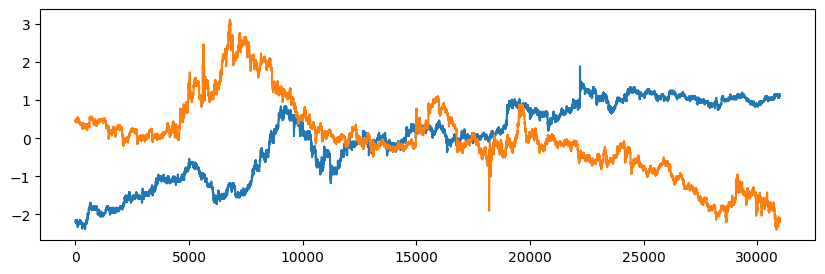

In [25]:
plt.figure(figsize=(10,3))
k.plot()
s.plot()

In [60]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame({'kelp': KELP["mid_price"], 'squid': SQUID["mid_price"]})

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)


time_step = 60  

X, y = create_dataset(scaled_data, time_step)

train_size = X.shape[0] - 1000
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2)) 

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/Users/karin/Desktop/Prosperity3/Prosperity3/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


936/936 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0151
Epoch 2/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0021
Epoch 3/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0015
Epoch 4/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 9.6506e-04
Epoch 5/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 7.3549e-04
Epoch 6/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 5.9133e-04
Epoch 7/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 5.7322e-04
Epoch 8/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 5.4283e-04
Epoch 9/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 5.4126e-04
Epoch 10/10
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 5.3957e-04


In [17]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [18]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'RMSE: {rmse}')


RMSE: 2.0871978804185543


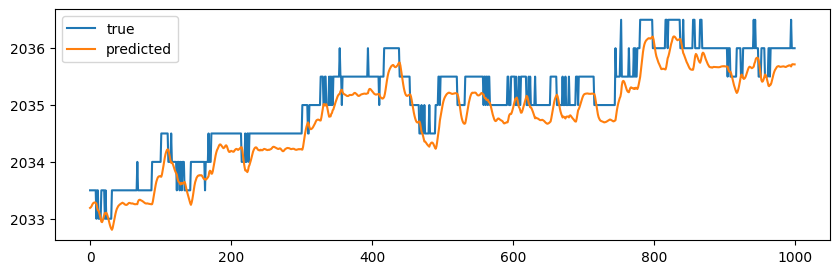

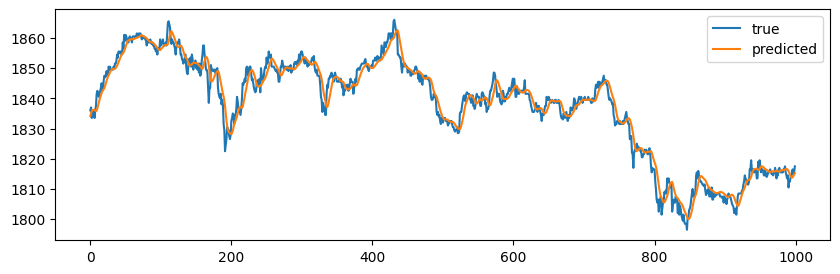

In [75]:
plt.figure(figsize=(10, 3))
plt.plot(kelp["timestamp"]/100, kelp["mid_price"], label="true")
plt.plot(y_pred_rescaled[:, 0], label='predicted')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(squid["timestamp"]/100, squid["mid_price"], label="true")
plt.plot(y_pred_rescaled[:, 1], label='predicted')
plt.legend()
plt.show()